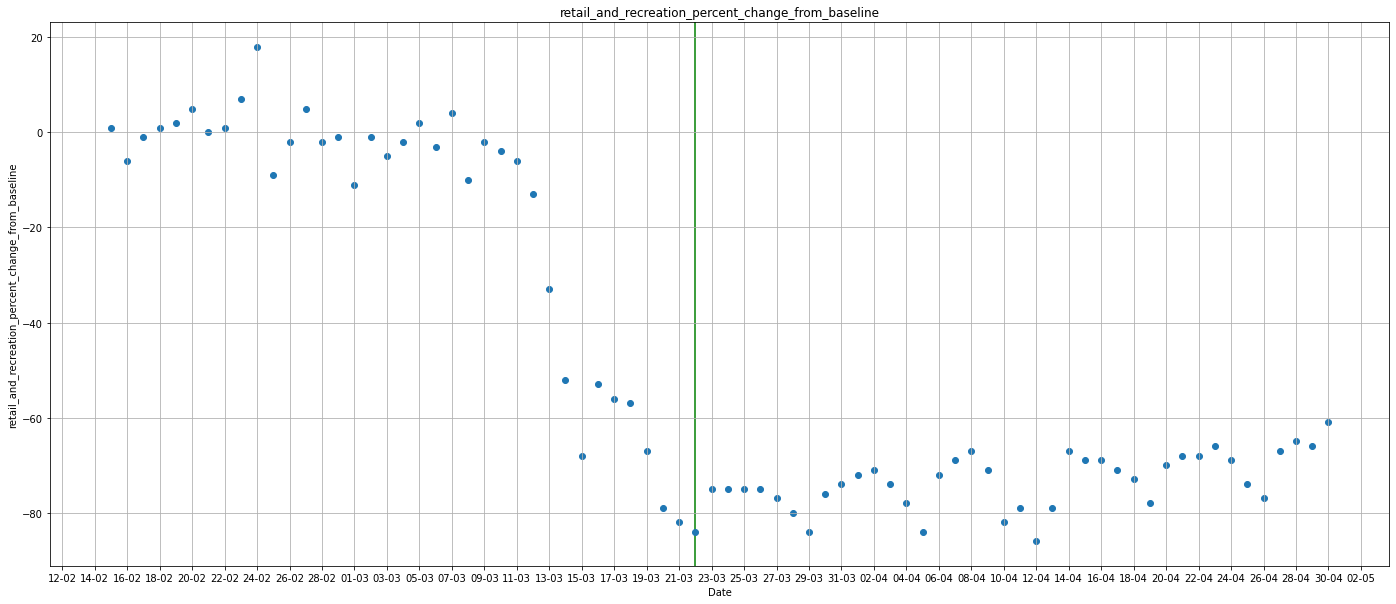

Linear Regression Model Score: 0.3154395678993088


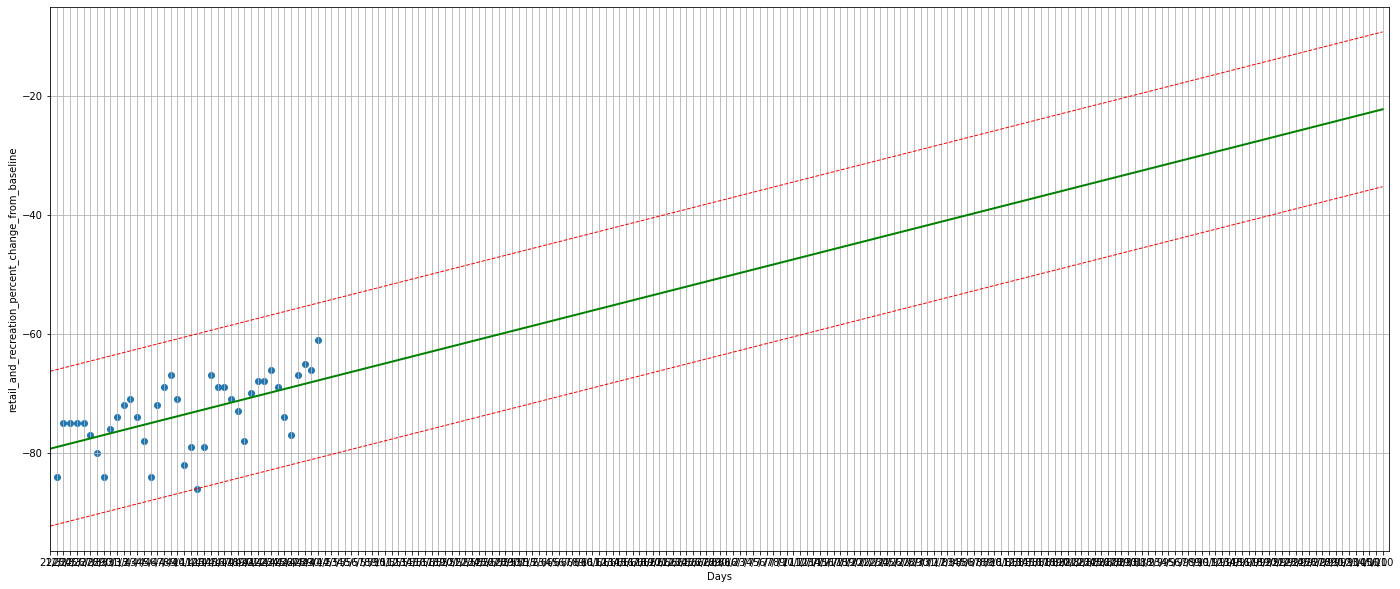

In [54]:
import pandas as pd
import math
import numpy as np
from sklearn import preprocessing, linear_model
from sklearn.metrics import max_error
# sklean.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style

from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates


data = pd.read_csv('Global_Mobility_Report.csv')
data = data.loc[data.sub_region_1 == 'Porto District']

data = data.reset_index(drop=True)
# print(data)

dates = data['date']
date_format = [pd.to_datetime(d) for d in dates]

# rolling_average_days = 7
# data['retail_and_recreation_percent_change_from_baseline_moving'] = data['retail_and_recreation_percent_change_from_baseline'].rolling(window=rolling_average_days).mean()
# variable = 'retail_and_recreation_percent_change_from_baseline_moving'

variable = 'retail_and_recreation_percent_change_from_baseline'

fig, ax = plt.subplots(figsize=(24, 10))
ax.grid()
ax.scatter(date_format, data[variable])
ax.set(xlabel="Date", ylabel=variable, title=variable)
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.axvline(datetime(2020, 3, 22), c="green", zorder=0)
fig.savefig(variable + '.png')
plt.show()

# prepare the lists for the model
X = date_format
y = data['retail_and_recreation_percent_change_from_baseline'].tolist()[1:]
# date format is not suitable for modeling, let's transform the date into incrementals number starting from starting_date
starting_date = 35
day_numbers = []
for i in range(1, len(X)):
    day_numbers.append([i])
X = day_numbers
# let's train our model only with data after the peak
X = X[starting_date:]
y = y[starting_date:]
# Instantiate Linear Regression
linear_regr = linear_model.LinearRegression()
# Train the model using the training sets
linear_regr.fit(X, y)
print("Linear Regression Model Score: %s" % (linear_regr.score(X, y)))

y_pred = linear_regr.predict(X)
error = max_error(y, y_pred)

X_test = []
future_days = 200
for i in range(starting_date, starting_date + future_days):
    X_test.append([i])
y_pred_linear = linear_regr.predict(X_test)

y_pred_max = []
y_pred_min = []
for i in range(0, len(y_pred_linear)):
    y_pred_max.append(y_pred_linear[i] + error)
    y_pred_min.append(y_pred_linear[i] - error)

# convert date of the epidemic peak into datetime format
date_zero = datetime.strptime(data['date'][starting_date], '%Y-%m-%d')
# creating x_ticks for making the plot more appealing
date_prev = []
x_ticks = []
step = 1
data_curr = date_zero
x_current = starting_date
n = int(future_days / step)
for i in range(0, n):
    date_prev.append(str(data_curr.day) + "/" + str(data_curr.month))
    x_ticks.append(x_current)
    data_curr = data_curr + timedelta(days=step)
    x_current = x_current + step

# plot known data
plt.figure(figsize=(24, 10))
plt.grid()
plt.scatter(X, y)
# plot linear regression prediction
plt.plot(X_test, y_pred_linear, color='green', linewidth=2)
# plot maximum error
plt.plot(X_test, y_pred_max, color='red', linewidth=1, linestyle='dashed')
# plot minimum error
plt.plot(X_test, y_pred_min, color='red', linewidth=1, linestyle='dashed')
plt.xlabel('Days')
plt.xlim(starting_date, starting_date + future_days)
plt.xticks(x_ticks, date_prev)
plt.ylabel('retail_and_recreation_percent_change_from_baseline')
plt.yscale('linear')
# plt.yscale('log')
# plt.gca().invert_yaxis()
plt.savefig('retail_and_recreation_percent_change_from_baseline_prediction.png')
plt.show()
